# Assignment 2: Solving the Saleman Problem using Simulated Annealing

## Data Preparation

In [1]:
!curl https://raw.githubusercontent.com/hflabs/city/ae661bffe572880472249097c9b29c42b09650ea/city.csv > city.csv
! pip install scikit-learn # we will use it to calculate the distances between cities

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  316k  100  316k    0     0   576k      0 --:--:-- --:--:-- --:--:--  578k
ERROR: Invalid requirement: '#'

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import random
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import haversine_distances
from typing import List

# seed for reproducibility
random.seed(0) 
np.random.seed(0)
# read the csv file
org_df = pd.read_csv("city.csv")

# filter the top 30 cities by population
CITIES_DF = org_df.sort_values("population", ascending=False).iloc[:30, :][['address', 'geo_lat', 'geo_lon']].reset_index()
CITIES_DF

,index,address,geo_lat,geo_lon
0,509,г Москва,55.754047,37.620405
1,786,г Санкт-Петербург,59.939131,30.315900
2,647,г Новосибирск,55.028191,82.921149
3,832,г Екатеринбург,56.838522,60.605491
4,619,г Нижний Новгород,56.324063,44.005391
5,927,г Казань,55.794358,49.111497
6,782,г Самара,53.195031,50.106952
7,656,г Омск,54.984857,73.367452
8,1064,г Челябинск,55.160262,61.400808
9,757,г Ростов-на-Дону,47.222457,39.718803


In [3]:
# define a function to get all the attributes of a given city just by its name
def get_city_by_name(cities: pd.DataFrame, city_name: str) -> pd.Series:
  return cities[cities['address'] == city_name].iloc[0, :]    

Since the coordinates are geosdic, we need to use the Haversine formula to calculate the distance between 2 cities
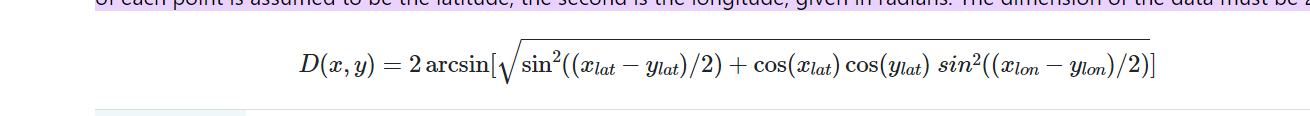

In [4]:
EARTH_RADIUS = 6371

def _distance_haversine(x_lat:float, x_lon:float, y_lat:float, y_lon:float, to_rad: bool = True):

	if to_rad:
		x_lat = np.deg2rad(x_lat)
		x_lon = np.deg2rad(x_lon)
		y_lat = np.deg2rad(y_lat)
		y_lon = np.deg2rad(y_lon)

	# calculate the distance
	dis = haversine_distances(np.asarray([[x_lat, x_lon], [y_lat, y_lon]]))
	return dis[0, 1]

def distance_cities(city1_name: str, city2_name: str):
	# get the information about the first city
	c1_info = get_city_by_name(cities=CITIES_DF, city_name=city1_name)
	c2_info = get_city_by_name(cities=CITIES_DF, city_name=city2_name)

	# return the distance using the formula and the earth radius
	return _distance_haversine(c1_info.geo_lat, c1_info.geo_lon, c2_info.geo_lat, c2_info.geo_lon) * EARTH_RADIUS

In [5]:
# let's verify the correctness of the formula really quick
distance_cities(city1_name="г Москва", city2_name="г Санкт-Петербург")
# the read distance between Moscow and Saint Peter is around 700k,sounds good so far.

634.4368333744881

# Simulated Annealing: utility functions

In [6]:
# let's define some utility functions
def cities_random_permutation() -> List[str]:
	# extract all names
	city_names = list(CITIES_DF['address'])
	# shuffle
	random.shuffle(city_names)
	return city_names

def path_length(city_names_order: List[str]) -> float:
	# let's make it a closed path
	if city_names_order[-1] != city_names_order[0]:
		city_names_order = city_names_order + [city_names_order[0]] 	

	path_distance = 0
	for src, dst in zip(city_names_order, city_names_order[1:]):
		path_distance += distance_cities(city1_name=src, city2_name=dst)

	return path_distance	

In [7]:
def propose_new_path(path: List[str]) -> List[str]:
	# this is done by switching 2 cities
	# select 2 city indices at random
	n = len(path)
	c_i1, c_i2 = random.randint(0, n - 1), random.randint(0, n - 2)
	while c_i2 == c_i1:
		c_i2 = random.randint(0, n-1)

	new_path = []
	for city_index, city in enumerate(path):
		# if we find the first city, insert the 2nd one
		
		if city_index == c_i2:
			new_path.append(path[c_i1])
		elif city_index == c_i1: # insert the 1st one since we encountered the 2nd city
			new_path.append(path[c_i2])
		else:
			# otherwise insert the same city
			new_path.append(city)

	return new_path

In [8]:
def target_distribution(path: List[str], temperature: float) -> float:
	return np.exp(-path_length(path) / temperature)

def accept(threshold: float) -> bool:
	return random.uniform(0, 1) <= threshold 

def update_path(path: List[str], proposed_path: List[str], temperature: float) -> List [str]:
	alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
	if accept(alpha):
		return proposed_path
	else:
		return path
	
def update_temperature(T, cooling_factor):
	if not  (0 < cooling_factor < 1): 
		raise ValueError(f"The cooling factor does not belong to the [0, 1] range.")
	return cooling_factor * T

In [9]:
# let's put everything together now
def simulated_annealing(cooling_factor, num_iterations: int = 10 ** 4, display_per_iterations: int = 10 ** 3):
	current_path = cities_random_permutation()

	temp = path_length(current_path) / 100

	paths = []
	distances = []

	for i in range(num_iterations):
		if i % display_per_iterations == 0:
			print("Current path length", path_length(current_path))
			print("Temp", temp)
			print("Iteration", i)
		paths.append(current_path)
		distances.append(path_length(current_path))
		proposed_path = propose_new_path(current_path)

		# update the path
		current_path = update_path(current_path, proposed_path, temp)
		# update the temperature
		temp = update_temperature(temp, cooling_factor)

		if temp <= 10 ** -6:
			# breka
			break

	return paths, distances

paths_slow, distances_slow = simulated_annealing(0.9999)

Current path length 61078.260369463555
Temp 610.7826036946356
Iteration 0
Current path length 27818.103011079307
Temp 552.6561906362464
Iteration 1000
Current path length 28502.06591418865
Temp 500.0615001164439
Iteration 2000
Current path length 27247.455691978954
Temp 452.47209410759393
Iteration 3000


In [10]:
paths_middle, distances_middle = simulated_annealing(0.9975)

Current path length 58040.2900301203
Temp 580.402900301203
Iteration 0
Current path length 21811.391321791027
Temp 47.4934734217203
Iteration 1000


C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value enc

Current path length 21173.6151612401
Temp 3.886317619172949
Iteration 2000


C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value enc

Current path length 21173.6151612401
Temp 0.318011371856976
Iteration 3000


C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value enc

Current path length 21173.6151612401
Temp 0.026022379676697047
Iteration 4000


C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value enc

Current path length 21173.6151612401
Temp 0.0021293711607983865
Iteration 5000


C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value enc

Current path length 21173.6151612401
Temp 0.00017424315519077053
Iteration 6000


C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value enc

Current path length 21173.6151612401
Temp 1.4258048427523295e-05
Iteration 7000


C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value enc

Current path length 21173.6151612401
Temp 1.1667140941004273e-06
Iteration 8000


C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value enc

Current path length 21173.6151612401
Temp 9.547041338034133e-08
Iteration 9000


C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value enc

In [11]:
paths_fast, distances_fast = simulated_annealing(0.995)

Current path length 68575.184111751
Temp 685.75184111751
Iteration 0


C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value enc

Current path length 25020.59646616642
Temp 4.562971203672082
Iteration 1000


C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value enc

Current path length 25020.59646616642
Temp 0.03036186701534912
Iteration 2000


C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value enc

Current path length 25020.59646616642
Temp 0.00020202690911480729
Iteration 3000


C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value enc

Current path length 25020.59646616642
Temp 1.3442807053284673e-06
Iteration 4000


C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value enc

Current path length 25020.59646616642
Temp 8.944801574385712e-09
Iteration 5000


C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value encountered in scalar divide
  alpha = target_distribution(proposed_path, temperature) / target_distribution(path, temperature)
C:\Users\bouab\AppData\Local\Temp\ipykernel_11036\1606938902.py:8: RuntimeWarning: invalid value enc

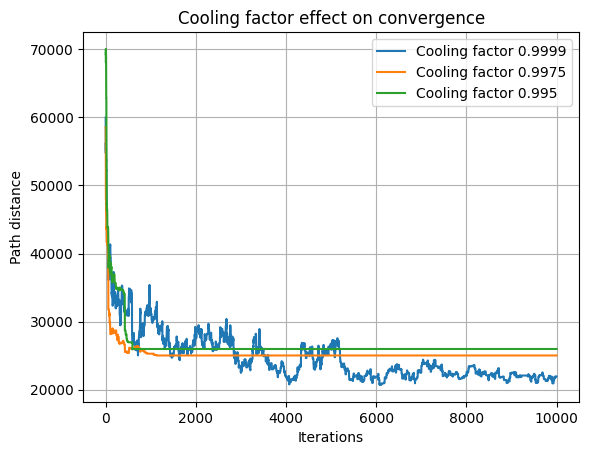

In [ ]:
import matplotlib.pyplot as plt

plt.plot(distances_slow, label="Cooling factor 0.9999")
plt.plot(distances_middle, label="Cooling factor 0.9975")
plt.plot(distances_fast, label="Cooling factor 0.995")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Path distance")
plt.title("Cooling factor effect on convergence")
plt.grid()
plt.savefig('plots.png')
plt.show()